## dataload

In [17]:
import mlflow
import mlflow.lightgbm
from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import pandas as pd
import os
import random
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np
from utils import custom_train_test_split, lgbm_predict, post_slack, title2filename
os.environ["LOGNAME"]='cwj'
SEED=13

## 1. Îç∞Ïù¥ÌÑ∞ Î°úÎî©
data_dir = '/opt/ml/input/data' # Í≤ΩÎ°ú
after_fe_path = os.path.join(data_dir, 'lgbm_tag_cluster.pkl')
df = pd.read_pickle(after_fe_path)

train_df = df[df.kind=='train']
train, valid = custom_train_test_split(train_df, ratio=0.7, seed=SEED) # ÌõàÎ†®Îç∞Ïù¥ÌÑ∞ split
test = df[df.kind=='test'] # ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞
train2 = test[test.answerCode!=-1] # ÌÖåÏä§Ìä∏Îç∞Ïù¥ÌÑ∞ ÎßàÏßÄÎßâ Ï†úÏ∂ú 2Î≤àÏ®∞Í∫ºÍπåÏßÄ ÌõàÎ†®Îç∞Ïù¥ÌÑ∞Î°ú ÏÇ¨Ïö©
train = pd.concat([train,train2]) # ÌõàÎ†®Îç∞Ïù¥ÌÑ∞ Î≥ëÌï©
train.shape, valid.shape, test.shape

x_train = train.drop('answerCode',axis=1)
y_train = train[['answerCode']]

x_valid = valid.drop('answerCode',axis=1)
y_valid = valid[['answerCode']]
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((1845539, 57), (1974, 57), (260114, 57))

((1845539, 56), (1845539, 1), (1974, 56), (1974, 1))

In [18]:
df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'kind', 'uidIdx', 'assIdx', 'testIdx',
       'user_correct_answer', 'user_total_answer', 'user_acc', 'month', 'day',
       'hour', 'dayname', 'big_category', 'problem_num', 'mid_category',
       'test_mean', 'test_std', 'test_sum', 'tag_mean', 'tag_std', 'tag_sum',
       'Timestamp2', 'solvetime', 'solvesec', 'solvesec_3600', 'time_category',
       'solvesec_cumsum', 'solvecumsum_category', 'big_category_cumconut',
       'big_category_answer', 'big_category_user_cum_acc',
       'mid_category_cumconut', 'mid_category_answer',
       'mid_category_user_cum_acc', 'ass_acc_mean', 'ass_difficulty',
       'ass_acc_std', 'pb_num_acc_mean', 'pb_num_difficulty', 'pb_num_acc_std',
       'assess_count', 'left_asymptote', 'elo_assessmentItemID',
       'elo_problem_num', 'user_tag_cluster', 'tag_cluster',
       'elo_big_category', 'elo_mid_category', 'elo_user_tag_cluster',
       'elo_tag_cl

## user_tag_cluster Ï∂îÍ∞Ä

([0, 1, 2, 3, 6, 7, 8, 9, 11, 21, 23, 31],
 'üåà(12/06 Tue)[LGBM user_tag_cluster Ï∂îÍ∞Ä lr 0.023] ÌîºÏ≤ò: 32Í∞ú',
 'ÏÇ¨Ïö©Îêú ÌîºÏ≤ò(32)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_cumconut, big_category_user_cum_acc, mid_category_cumconut, mid_category_user_cum_acc, assess_count, elo_assessmentItemID, elo_problem_num, user_tag_cluster')

[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20238
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.531009
[200]	valid_0's binary_logloss: 0.516933
[300]	valid_0's binary_logloss: 0.512619
[400]	valid_0's binary_logloss: 0.510414
[500]	valid_0's binary_logloss: 0.50889
[600]	valid_0's binary_logloss: 0.507945
[700]	valid_0's binary_logloss: 0.506726
[800]	valid_0's binary_logloss: 0.505996
[900]	valid_0's binary_logloss: 0.505279
[1000

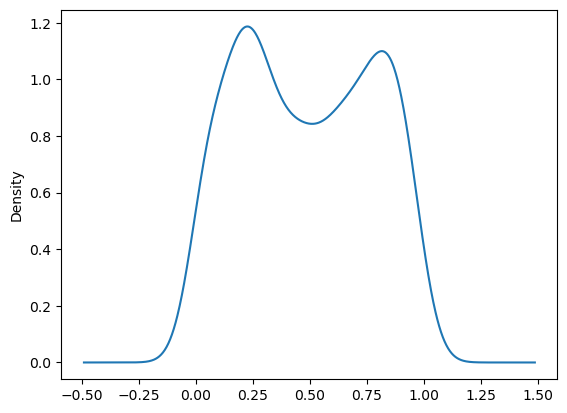

In [31]:
# Hyper parameter ÏÑ§Ï†ï
params = {
#     "max_depth": 8,  # 8,
#     "min_data_in_leaf": 1000,
    # "feature_fraction": 0.6,  # 0.8,
#     "bagging_fraction": 0.75,
    # "max_cat_group": 64,
    "objective": "binary",
#     "boosting": "gbdt",  # dart
    "learning_rate": 0.023,  # 0.01,
    # "bagging_freq": 5,
    "seed": 42,
    # "max_bin": 50,
#     "num_leaves": 80,  # 40,
#     "metric": "auc",
}

### ÌîºÏ≤ò ÏÑ§Ï†ï
# ÏÇ¨Ïö©Ìï† Feature ÏÑ§Ï†ï
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_cumconut',
         'big_category_user_cum_acc',
         'mid_category_cumconut',
         'mid_category_user_cum_acc',
         'assess_count',
         'elo_assessmentItemID',
         'elo_problem_num',
         'user_tag_cluster'
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category','user_tag_cluster']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### ÌïôÏäµ Î∞è ÏòàÏ∏°

date = datetime.now().strftime('%m/%d %a')
title=f"üåà({date})[LGBM user_tag_cluster Ï∂îÍ∞Ä lr 0.023] ÌîºÏ≤ò: {len(FEATS)}Í∞ú"
using_feats=", ".join(FEATS)
desc=f"ÏÇ¨Ïö©Îêú ÌîºÏ≤ò({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model2 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=100,
    )
    preds = model2.predict(x_valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model2_run_id=run.info.run_id
    post_slack("done")
    print(f"{model2_run_id=}")
    file_name = title2filename(title)
    test_preds = lgbm_predict(test, model2, FEATS, f'{file_name}.csv')

q = pd.Series(test_preds).plot(kind='kde')

In [16]:
### Ï†úÏ∂ú mlflow Îì±Î°ù
# Ï†úÏ∂úÏãú
LB_AUC=0.8205
run_id = 'ec8e6ddbdf77445abec6a353b1b6e620'
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()

<ActiveRun: >

Active run_id: ec8e6ddbdf77445abec6a353b1b6e620


## tag_clusterÎßå Ï∂îÍ∞Ä

([0, 1, 2, 3, 6, 7, 8, 9, 11, 21, 23, 31],
 'üåà(12/06 Tue)[LGBM tag_clusterÎßå Ï∂îÍ∞Ä lr 0.023] ÌîºÏ≤ò: 32Í∞ú',
 'ÏÇ¨Ïö©Îêú ÌîºÏ≤ò(32)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_cumconut, big_category_user_cum_acc, mid_category_cumconut, mid_category_user_cum_acc, assess_count, elo_assessmentItemID, elo_problem_num, tag_cluster')

[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20245
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.530324
[200]	valid_0's binary_logloss: 0.516592
[300]	valid_0's binary_logloss: 0.512866
[400]	valid_0's binary_logloss: 0.510718
[500]	valid_0's binary_logloss: 0.509138
[600]	valid_0's binary_logloss: 0.507845
[700]	valid_0's binary_logloss: 0.506978
[800]	valid_0's binary_logloss: 0.506143
[900]	valid_0's binary_logloss: 0.505367
[100

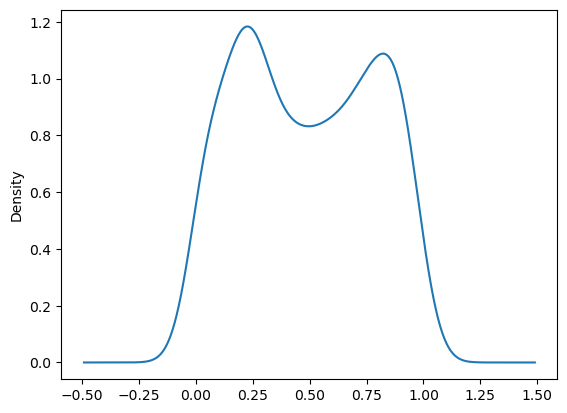

In [6]:
# Hyper parameter ÏÑ§Ï†ï
params = {
#     "max_depth": 8,  # 8,
#     "min_data_in_leaf": 1000,
    # "feature_fraction": 0.6,  # 0.8,
#     "bagging_fraction": 0.75,
    # "max_cat_group": 64,
    "objective": "binary",
#     "boosting": "gbdt",  # dart
    "learning_rate": 0.023,  # 0.01,
    # "bagging_freq": 5,
    "seed": 42,
    # "max_bin": 50,
#     "num_leaves": 80,  # 40,
#     "metric": "auc",
}

### ÌîºÏ≤ò ÏÑ§Ï†ï
# ÏÇ¨Ïö©Ìï† Feature ÏÑ§Ï†ï
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_cumconut',
         'big_category_user_cum_acc',
         'mid_category_cumconut',
         'mid_category_user_cum_acc',
         'assess_count',
         'elo_assessmentItemID',
         'elo_problem_num',
         'tag_cluster'
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category','tag_cluster']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### ÌïôÏäµ Î∞è ÏòàÏ∏°

date = datetime.now().strftime('%m/%d %a')
title=f"üåà({date})[LGBM tag_clusterÎßå Ï∂îÍ∞Ä lr 0.023] ÌîºÏ≤ò: {len(FEATS)}Í∞ú"
using_feats=", ".join(FEATS)
desc=f"ÏÇ¨Ïö©Îêú ÌîºÏ≤ò({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model3 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=100,
    )
    preds = model3.predict(x_valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model3_run_id=run.info.run_id
    post_slack("done")
    print(f"{model3_run_id=}")
    file_name = title2filename(title)
    test_preds = lgbm_predict(test, model3, FEATS, f'{file_name}.csv')

q = pd.Series(test_preds).plot(kind='kde')

In [ ]:
### Ï†úÏ∂ú mlflow Îì±Î°ù
# Ï†úÏ∂úÏãú
LB_AUC=0.8205
run_id = 'ec8e6ddbdf77445abec6a353b1b6e620'
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()

## user_tag_clusterÏôÄ tag_clusterÎëò Îã§ Ï∂îÍ∞Ä

([0, 1, 2, 3, 6, 7, 8, 9, 11, 21, 23, 31, 32],
 'üåà(12/06 Tue)[LGBM user_tag_cluster, tag_cluster Îëò Îã§ Ï∂îÍ∞Ä lr 0.023] ÌîºÏ≤ò: 33Í∞ú',
 'ÏÇ¨Ïö©Îêú ÌîºÏ≤ò(33)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_cumconut, big_category_user_cum_acc, mid_category_cumconut, mid_category_user_cum_acc, assess_count, elo_assessmentItemID, elo_problem_num, user_tag_cluster, tag_cluster')

[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20261
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.530324
[200]	valid_0's binary_logloss: 0.516539
[300]	valid_0's binary_logloss: 0.512871
[400]	valid_0's binary_logloss: 0.510555
[500]	valid_0's binary_logloss: 0.508868
[600]	valid_0's binary_logloss: 0.50762
[700]	valid_0's binary_logloss: 0.506594
[800]	valid_0's binary_logloss: 0.50587
[900]	valid_0's binary_logloss: 0.505299
[1000]

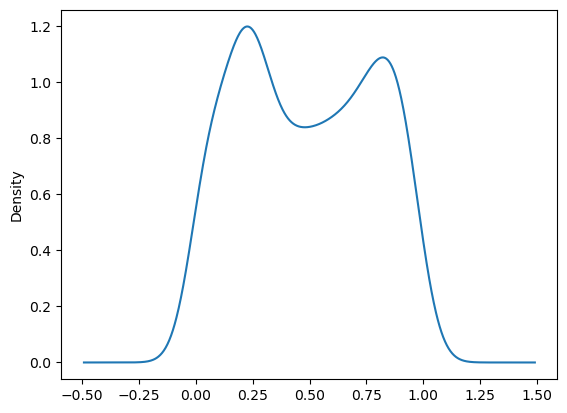

In [7]:
# Hyper parameter ÏÑ§Ï†ï
params = {
#     "max_depth": 8,  # 8,
#     "min_data_in_leaf": 1000,
    # "feature_fraction": 0.6,  # 0.8,
#     "bagging_fraction": 0.75,
    # "max_cat_group": 64,
    "objective": "binary",
#     "boosting": "gbdt",  # dart
    "learning_rate": 0.023,  # 0.01,
    # "bagging_freq": 5,
    "seed": 42,
    # "max_bin": 50,
#     "num_leaves": 80,  # 40,
#     "metric": "auc",
}

### ÌîºÏ≤ò ÏÑ§Ï†ï
# ÏÇ¨Ïö©Ìï† Feature ÏÑ§Ï†ï
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_cumconut',
         'big_category_user_cum_acc',
         'mid_category_cumconut',
         'mid_category_user_cum_acc',
         'assess_count',
         'elo_assessmentItemID',
         'elo_problem_num',
         'user_tag_cluster',
         'tag_cluster',
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category',
             'user_tag_cluster','tag_cluster']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### ÌïôÏäµ Î∞è ÏòàÏ∏°

date = datetime.now().strftime('%m/%d %a')
title=f"üåà({date})[LGBM user_tag_cluster, tag_cluster Îëò Îã§ Ï∂îÍ∞Ä lr 0.023] ÌîºÏ≤ò: {len(FEATS)}Í∞ú"
using_feats=", ".join(FEATS)
desc=f"ÏÇ¨Ïö©Îêú ÌîºÏ≤ò({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model4 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=100,
    )
    preds = model4.predict(x_valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model4_run_id=run.info.run_id
    post_slack("done")
    print(f"{model4_run_id=}")
    file_name = title2filename(title)
    test_preds = lgbm_predict(test, model4, FEATS, f'{file_name}.csv')

q = pd.Series(test_preds).plot(kind='kde')

In [ ]:
### Ï†úÏ∂ú mlflow Îì±Î°ù
# Ï†úÏ∂úÏãú
LB_AUC=0.8205
run_id = 'ec8e6ddbdf77445abec6a353b1b6e620'
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()

### gbdtÎ°ú Î≥ÄÍ≤Ω

([0, 1, 2, 3, 6, 7, 8, 9, 11, 21, 23, 31, 32],
 'üåà(12/06 Tue)[LGBM user_tag_cluster, tag_cluster Îã§ Ï∂îÍ∞Ä lr 0.023 gbdt] ÌîºÏ≤ò: 33Í∞ú',
 'ÏÇ¨Ïö©Îêú ÌîºÏ≤ò(33)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_cumconut, big_category_user_cum_acc, mid_category_cumconut, mid_category_user_cum_acc, assess_count, elo_assessmentItemID, elo_problem_num, user_tag_cluster, tag_cluster')

[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20261
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.530324
[200]	valid_0's binary_logloss: 0.516539
[300]	valid_0's binary_logloss: 0.512871
[400]	valid_0's binary_logloss: 0.510555
[500]	valid_0's binary_logloss: 0.508868
[600]	valid_0's binary_logloss: 0.50762
[700]	valid_0's binary_logloss: 0.506594
[800]	valid_0's binary_logloss: 0.50587
[900]	valid_0's binary_logloss: 0.505299
[1000]

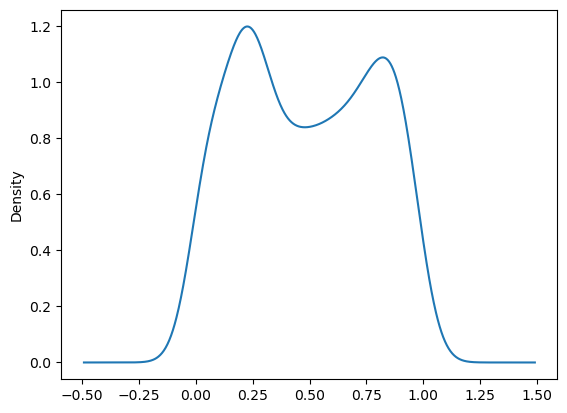

In [8]:
## user_tag_clusterÏôÄ tag_clusterÎëò Îã§ Ï∂îÍ∞Ä

# Hyper parameter ÏÑ§Ï†ï
params = {
#     "max_depth": 8,  # 8,
#     "min_data_in_leaf": 1000,
    # "feature_fraction": 0.6,  # 0.8,
#     "bagging_fraction": 0.75,
    # "max_cat_group": 64,
    "objective": "binary",
    "boosting": "gbdt",  # dart
    "learning_rate": 0.023,  # 0.01,
    # "bagging_freq": 5,
    "seed": 42,
    # "max_bin": 50,
#     "num_leaves": 80,  # 40,
#     "metric": "auc",
}

### ÌîºÏ≤ò ÏÑ§Ï†ï
# ÏÇ¨Ïö©Ìï† Feature ÏÑ§Ï†ï
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_cumconut',
         'big_category_user_cum_acc',
         'mid_category_cumconut',
         'mid_category_user_cum_acc',
         'assess_count',
         'elo_assessmentItemID',
         'elo_problem_num',
         'user_tag_cluster',
         'tag_cluster',
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category',
             'user_tag_cluster','tag_cluster']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### ÌïôÏäµ Î∞è ÏòàÏ∏°

date = datetime.now().strftime('%m/%d %a')
title=f"üåà({date})[LGBM user_tag_cluster, tag_cluster Îã§ Ï∂îÍ∞Ä lr 0.023 gbdt] ÌîºÏ≤ò: {len(FEATS)}Í∞ú"
using_feats=", ".join(FEATS)
desc=f"ÏÇ¨Ïö©Îêú ÌîºÏ≤ò({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model41 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=100,
    )
    preds = model41.predict(x_valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model41_run_id=run.info.run_id
    post_slack("done")
    print(f"{model41_run_id=}")
    file_name = title2filename(title)
    test_preds = lgbm_predict(test, model41, FEATS, f'{file_name}.csv')

q = pd.Series(test_preds).plot(kind='kde')

In [34]:
### Ï†úÏ∂ú mlflow Îì±Î°ù
# Ï†úÏ∂úÏãú
LB_AUC=0.819
run_id = '5a3085a87fea40aeb61bfd1da5485281'
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()

<ActiveRun: >

Active run_id: 5a3085a87fea40aeb61bfd1da5485281


## Í∏∞Ï°¥ user_acc Ï†úÏô∏

([0, 1, 2, 3, 6, 7, 8, 9, 11, 20, 22],
 'üåà(12/06 Tue)[LGBM Í∏∞Ï°¥ user_acc Ï†úÏô∏ lr 0.023] ÌîºÏ≤ò: 30Í∞ú',
 'ÏÇ¨Ïö©Îêú ÌîºÏ≤ò(30)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_cumconut, big_category_user_cum_acc, mid_category_cumconut, mid_category_user_cum_acc, assess_count, elo_assessmentItemID, elo_problem_num')

[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5061
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.532488
[200]	valid_0's binary_logloss: 0.519919
[300]	valid_0's binary_logloss: 0.515803
[400]	valid_0's binary_logloss: 0.513256
[500]	valid_0's binary_logloss: 0.511818
[600]	valid_0's binary_logloss: 0.510693
[700]	valid_0's binary_logloss: 0.510055
[800]	valid_0's binary_logloss: 0.509759
[900]	valid_0's binary_logloss: 0.509404
[1000

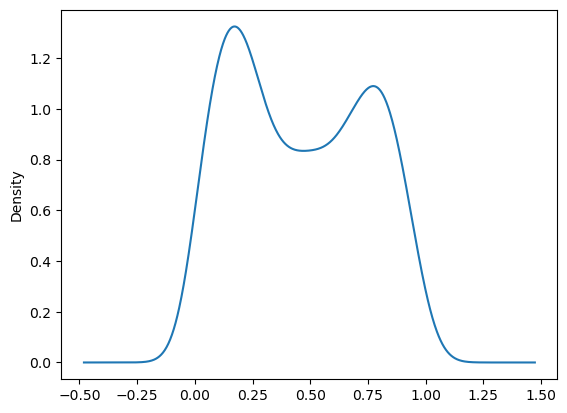

In [30]:
# Hyper parameter ÏÑ§Ï†ï
params = {
#     "max_depth": 8,  # 8,
#     "min_data_in_leaf": 1000,
    # "feature_fraction": 0.6,  # 0.8,
#     "bagging_fraction": 0.75,
    # "max_cat_group": 64,
    "objective": "binary",
#     "boosting": "gbdt",  # dart
    "learning_rate": 0.023,  # 0.01,
    # "bagging_freq": 5,
    "seed": 42,
    # "max_bin": 50,
#     "num_leaves": 80,  # 40,
#     "metric": "auc",
}

### ÌîºÏ≤ò ÏÑ§Ï†ï
# ÏÇ¨Ïö©Ìï† Feature ÏÑ§Ï†ï
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_cumconut',
         'big_category_user_cum_acc',
         'mid_category_cumconut',
         'mid_category_user_cum_acc',
         'assess_count',
         'elo_assessmentItemID',
         'elo_problem_num',
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### ÌïôÏäµ Î∞è ÏòàÏ∏°

date = datetime.now().strftime('%m/%d %a')
title=f"üåà({date})[LGBM Í∏∞Ï°¥ user_acc Ï†úÏô∏ lr 0.023] ÌîºÏ≤ò: {len(FEATS)}Í∞ú"
using_feats=", ".join(FEATS)
desc=f"ÏÇ¨Ïö©Îêú ÌîºÏ≤ò({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model5 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=3200,
#         categorical_feature=cat_feats_idx,
        early_stopping_rounds=100,
    )
    preds = model5.predict(x_valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model5_run_id=run.info.run_id
    post_slack("done")
    print(f"{model5_run_id=}")
    file_name = title2filename(title)
    test_preds = lgbm_predict(test, model5, FEATS, f'{file_name}.csv')

q = pd.Series(test_preds).plot(kind='kde')

In [35]:
### Ï†úÏ∂ú mlflow Îì±Î°ù
# Ï†úÏ∂úÏãú
LB_AUC=0.8220
run_id = 'f9b6bf94e8b542cf8efd237ab0bc0378'
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()

<ActiveRun: >

Active run_id: f9b6bf94e8b542cf8efd237ab0bc0378


### HP ÌäúÎãù

([0, 1, 2, 3, 6, 7, 8, 9, 11, 20, 22],
 'üåà(12/06 Tue)[LGBM Í∏∞Ï°¥ user_acc Ï†úÏô∏ HP ÌäúÎãù] ÌîºÏ≤ò: 30Í∞ú',
 'ÏÇ¨Ïö©Îêú ÌîºÏ≤ò(30)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_cumconut, big_category_user_cum_acc, mid_category_cumconut, mid_category_user_cum_acc, assess_count, elo_assessmentItemID, elo_problem_num')

[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5061
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.81474
[200]	valid_0's auc: 0.817979
[300]	valid_0's auc: 0.820315
[400]	valid_0's auc: 0.822657
[500]	valid_0's auc: 0.824094
[600]	valid_0's auc: 0.825376
[700]	valid_0's auc: 0.826685
[800]	valid_0's auc: 0.827407
[900]	valid_0's auc: 0.828086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2400]	valid_0's auc: 0.831085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2700]	valid_0's auc: 0.831495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3100]	valid_0's auc: 0.832046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

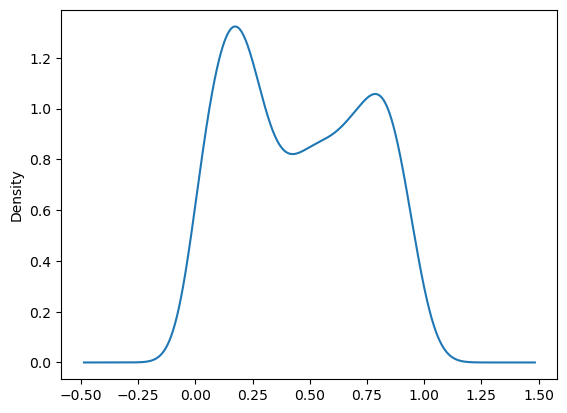

In [32]:
# TODO : tunning
params = {
    "max_depth": 8,  # 8,
    "min_data_in_leaf": 1000,
    # "feature_fraction": 0.6,  # 0.8,
    "bagging_fraction": 0.75,
    # "max_cat_group": 64,
    "objective": "binary",
    "boosting": "gbdt",  # dart
    "learning_rate": 0.01,  # 0.01,
    # "bagging_freq": 5,
    "seed": 42,
    # "max_bin": 50,
    "num_leaves": 80,  # 40,
    "metric": "auc",
}

### ÌîºÏ≤ò ÏÑ§Ï†ï
# ÏÇ¨Ïö©Ìï† Feature ÏÑ§Ï†ï
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_cumconut',
         'big_category_user_cum_acc',
         'mid_category_cumconut',
         'mid_category_user_cum_acc',
         'assess_count',
         'elo_assessmentItemID',
         'elo_problem_num',
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### ÌïôÏäµ Î∞è ÏòàÏ∏°

date = datetime.now().strftime('%m/%d %a')
title=f"üåà({date})[LGBM Í∏∞Ï°¥ user_acc Ï†úÏô∏ HP ÌäúÎãù] ÌîºÏ≤ò: {len(FEATS)}Í∞ú"
using_feats=", ".join(FEATS)
desc=f"ÏÇ¨Ïö©Îêú ÌîºÏ≤ò({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model51 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=3200,
#         categorical_feature=cat_feats_idx,
        early_stopping_rounds=100,
    )
    preds = model51.predict(x_valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model51_run_id=run.info.run_id
    post_slack("done")
    print(f"{model51_run_id=}")
    file_name = title2filename(title)
    test_preds = lgbm_predict(test, model51, FEATS, f'{file_name}.csv')

q = pd.Series(test_preds).plot(kind='kde')

## elo_big_category Ï∂îÍ∞Ä

## elo_pbnum, elo_ass 1ÏóêÏÑú ÎπºÎ≥¥Í∏∞

In [19]:
df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'kind', 'uidIdx', 'assIdx', 'testIdx',
       'user_correct_answer', 'user_total_answer', 'user_acc', 'month', 'day',
       'hour', 'dayname', 'big_category', 'problem_num', 'mid_category',
       'test_mean', 'test_std', 'test_sum', 'tag_mean', 'tag_std', 'tag_sum',
       'Timestamp2', 'solvetime', 'solvesec', 'solvesec_3600', 'time_category',
       'solvesec_cumsum', 'solvecumsum_category', 'big_category_cumconut',
       'big_category_answer', 'big_category_user_cum_acc',
       'mid_category_cumconut', 'mid_category_answer',
       'mid_category_user_cum_acc', 'ass_acc_mean', 'ass_difficulty',
       'ass_acc_std', 'pb_num_acc_mean', 'pb_num_difficulty', 'pb_num_acc_std',
       'assess_count', 'left_asymptote', 'elo_assessmentItemID',
       'elo_problem_num', 'user_tag_cluster', 'tag_cluster',
       'elo_big_category', 'elo_mid_category', 'elo_user_tag_cluster',
       'elo_tag_cl

In [27]:
cat_feats_idx

[0, 1, 2, 5, 6, 7, 8, 10, 13, 15, 25]

([0, 1, 2, 6, 7, 8, 10, 13, 15, 22],
 'üåà(12/06 Tue)[LGBM mid category Í¥ÄÎ†® Ï†úÏô∏, user_acc Ï∂îÍ∞Ä lr 0.023] ÌîºÏ≤ò: 24Í∞ú',
 'ÏÇ¨Ïö©Îêú ÌîºÏ≤ò(24)\nuidIdx, assIdx, KnowledgeTag, user_acc, user_correct_answer, user_total_answer, big_category, problem_num, month, day, dayname, hour, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_cumconut, big_category_user_cum_acc, assess_count, elo_assessmentItemID, elo_problem_num, elo_big_category, tag_cluster, elo_tag_cluster')

[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17409
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.535747
[200]	valid_0's binary_logloss: 0.522939
[300]	valid_0's binary_logloss: 0.51875
[400]	valid_0's binary_logloss: 0.516166
[500]	valid_0's binary_logloss: 0.514636
[600]	valid_0's binary_logloss: 0.513778
[700]	valid_0's binary_logloss: 0.512524
[800]	valid_0's binary_logloss: 0.511847
[900]	valid_0's binary_logloss: 0.511272
[1000

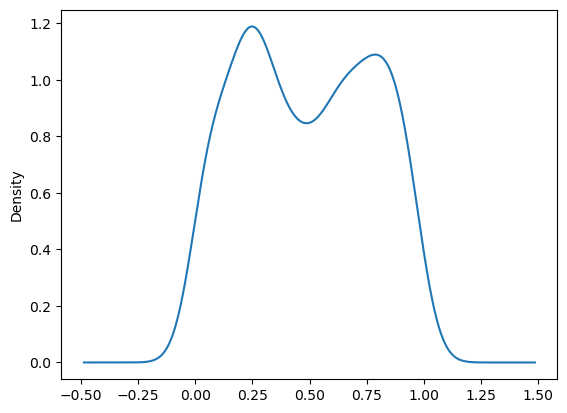

In [29]:
# Hyper parameter ÏÑ§Ï†ï
params = {
#     "max_depth": 8,  # 8,
#     "min_data_in_leaf": 1000,
    # "feature_fraction": 0.6,  # 0.8,
#     "bagging_fraction": 0.75,
    # "max_cat_group": 64,
    "objective": "binary",
#     "boosting": "gbdt",  # dart
    "learning_rate": 0.023,  # 0.01,
    # "bagging_freq": 5,
    "seed": 42,
    # "max_bin": 50,
#     "num_leaves": 80,  # 40,
#     "metric": "auc",
}

### ÌîºÏ≤ò ÏÑ§Ï†ï
# ÏÇ¨Ïö©Ìï† Feature ÏÑ§Ï†ï
FEATS = ['uidIdx',
         'assIdx',
         'KnowledgeTag',
         'user_acc',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'problem_num',
         'month','day','dayname','hour',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_cumconut',
         'big_category_user_cum_acc',
         'assess_count',
         'elo_assessmentItemID',
         'elo_problem_num',
         'elo_big_category',
         'tag_cluster',
         'elo_tag_cluster'
        ]

cat_feats = ['uidIdx','assIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category','tag_cluster']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### ÌïôÏäµ Î∞è ÏòàÏ∏°

date = datetime.now().strftime('%m/%d %a')
title=f"üåà({date})[LGBM mid category Í¥ÄÎ†® Ï†úÏô∏, user_acc Ï∂îÍ∞Ä lr 0.023] ÌîºÏ≤ò: {len(FEATS)}Í∞ú"
using_feats=", ".join(FEATS)
desc=f"ÏÇ¨Ïö©Îêú ÌîºÏ≤ò({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model6 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=100,
    )
    preds = model6.predict(x_valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model6_run_id=run.info.run_id
    post_slack("done")
    print(f"{model6_run_id=}")
    file_name = title2filename(title)
    test_preds = lgbm_predict(test, model6, FEATS, f'{file_name}.csv')

q = pd.Series(test_preds).plot(kind='kde')

## HP ÌäúÎãù

In [ ]:
# Hyper parameter ÏÑ§Ï†ï
params = {
    "max_depth": 8,  # 8,
#     "min_data_in_leaf": 1000,
    "feature_fraction": 0.6,  # 0.8,
    "bagging_fraction": 0.75,
    "max_cat_group": 64,
    "objective": "binary",
    "boosting": "gbdt",  # dart
    "learning_rate": 0.023,  # 0.01,
    # "bagging_freq": 5,
    "seed": 42,
    "max_bin": 50,
#     "num_leaves": 80,  # 40,
#     "metric": "auc",
     'lambda_l1': 9.5, 
     'lambda_l2': 0.005, 
     'min_child_samples': 20,
}